You need
LANGSMITH_API_KEY (and your LangSmith project name).

*   [OPENAI_API_KEY](https://platform.openai.com/api-keys)
*   [LANGSMITH_API_KEY](https://smith.langchain.com/o/dfb4c27f-730c-5be2-a2a4-34df91381a75/settings/apikeys)
*   [LangSmith project name](https://smith.langchain.com/o/dfb4c27f-730c-5be2-a2a4-34df91381a75/projects)



In [ ]:
!pip -q install -U langchain langchain-openai langgraph langsmith python-dotenv pydantic

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# LangSmith
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT", "langgraph-youtube-demo")
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

print("Tracing:", os.environ["LANGCHAIN_TRACING_V2"])
print("Project:", os.environ["LANGCHAIN_PROJECT"])


Tracing: true
Project: langgraph-youtube-demo


In [ ]:
from typing import List, Dict, Any, Optional, TypedDict, Literal
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)


# Single Agent

In [ ]:
SINGLE_AGENT_SYSTEM = """You are a helpful AI.
Task: Provide a well-reasoned recommendation to the user question.
Rules:
- Make your best effort without browsing the web.
- Be structured: Summary, Pros, Cons, Recommendation, Risks, Confidence (0-100).
"""

def single_agent_answer(question: str) -> str:
    msgs = [
        SystemMessage(content=SINGLE_AGENT_SYSTEM),
        HumanMessage(content=question),
    ]
    return llm.invoke(msgs).content

question = "Should a startup use open-source LLMs or closed models in 2026? Consider cost, speed, privacy, and reliability."
print(single_agent_answer(question))


### Summary
In 2026, the decision for a startup to use open-source large language models (LLMs) versus closed models will hinge on several factors, including cost, speed, privacy, and reliability. Both options have their merits and drawbacks, and the best choice will depend on the specific needs and goals of the startup.

### Pros and Cons

#### Open-Source LLMs
**Pros:**
- **Cost-Effective:** Generally, open-source models can be used without licensing fees, which can significantly reduce operational costs.
- **Customization:** Startups can modify and fine-tune the models to better suit their specific use cases.
- **Transparency:** Open-source models allow for greater scrutiny and understanding of the underlying algorithms, which can enhance trust and security.
- **Community Support:** There is often a vibrant community around open-source projects, providing support, updates, and shared innovations.

**Cons:**
- **Resource Intensive:** Running and maintaining open-source models may req

check langsmith tracing [link](https://smith.langchain.com/o/dfb4c27f-730c-5be2-a2a4-34df91381a75/projects/p/69f0386c-3cde-4b48-8d4d-e19b4e636514?timeModel=%7B%22duration%22%3A%227d%22%7D)

#Multi-Agent System with LangGraph + LangSmith

[Main idea](https://drive.google.com/file/d/1jWx_XLA-Iva_lQ0uIPtua9iWq06Ap929/view?usp=sharing)



*   Planner: Breaks the user’s question into a clear plan, key risks, and the structure of the final answer.
*   Researcher: Gathers and organizes relevant information needed to execute the plan.
*   Writer: Produces or revises the draft answer based on the plan, research, and feedback.
*   Critic: Evaluates the draft for quality, gaps, and risks, and assigns a score with concrete improvement suggestions.
*   finalizer: Produces the final, polished answer once the quality threshold is met.


In [ ]:
#Define structured outputs
class Plan(BaseModel):
    steps: List[str] = Field(..., description="Short ordered steps for solving the task.")
    key_risks: List[str] = Field(..., description="Major risks/unknowns that should be addressed.")
    desired_output_structure: List[str] = Field(..., description="Headings to include in final answer.")

class Critique(BaseModel):
    issues: List[str] = Field(..., description="Concrete problems with the current draft.")
    missing_points: List[str] = Field(..., description="Important missing considerations.")
    hallucination_risk: List[str] = Field(..., description="Claims that might be risky without sources.")
    score: int = Field(..., ge=0, le=100, description="Overall quality score of the draft.")
    fix_instructions: List[str] = Field(..., description="Actionable steps to improve the draft.")


In [ ]:
#Define LangGraph state

class GraphState(TypedDict):
    question: str
    plan: Optional[Dict[str, Any]]
    research_notes: List[str]
    draft: Optional[str]
    critique: Optional[Dict[str, Any]]
    iteration: int
    max_iterations: int


In [ ]:
# Agent nodes (Planner, Researcher, Writer, Critic, finalizer)

PLANNER_SYSTEM = """You are the Planner agent.
Create a concise plan with steps, key risks, and final output headings.
Return valid JSON matching the schema.
"""

RESEARCHER_SYSTEM = """You are the Researcher agent.
You do NOT browse the web. You reason from general knowledge.
Produce bullet research notes covering: cost, speed, privacy, reliability, compliance, vendor lock-in, iteration speed, support.
Keep it practical for startups.
"""

WRITER_SYSTEM = """You are the Writer agent.
Write a structured answer using the plan headings.
Use the research notes.
Be specific, actionable, and include a clear recommendation plus risks.
"""

CRITIC_SYSTEM = """You are the Critic agent.
Review the draft for:
- missing points
- weak reasoning
- overconfidence
- risky claims
Return JSON matching the schema.
"""

FUNALIZER_SYSTEM = """You are the finalizer agent.
Given the plan + research notes + (optional) critique, produce the FINAL answer.
If critique exists, incorporate fixes.
Output must be polished and concise with headings and a confidence score.
"""

def planner_node(state: GraphState) -> GraphState:
    structured_planner = llm.with_structured_output(Plan)
    plan_obj = structured_planner.invoke([
        SystemMessage(content=PLANNER_SYSTEM),
        HumanMessage(content=state["question"])
    ])
    state["plan"] = plan_obj.model_dump()
    return state

def researcher_node(state: GraphState) -> GraphState:
    resp = llm.invoke([
        SystemMessage(content=RESEARCHER_SYSTEM),
        HumanMessage(content=f"Question:\n{state['question']}\n\nPlan:\n{state['plan']}")
    ]).content

    # store as notes (simple split)
    notes = [line.strip("- ").strip() for line in resp.split("\n") if line.strip()]
    state["research_notes"] = notes
    return state

def writer_node(state: GraphState) -> GraphState:
    resp = llm.invoke([
        SystemMessage(content=WRITER_SYSTEM),
        HumanMessage(content=f"""
        Question:
        {state['question']}

        Plan:
        {state['plan']}

        Research notes:
        {state['research_notes']}

        If critique exists, you may improve the draft accordingly.
        Critique:
        {state.get('critique')}
        """)
            ]).content

    state["draft"] = resp
    return state



def critic_node(state: GraphState) -> GraphState:
    structured_critic = llm.with_structured_output(Critique)
    critique_obj = structured_critic.invoke([
        SystemMessage(content=CRITIC_SYSTEM),
        HumanMessage(content=f"""
    Question:
    {state['question']}

    Draft:
    {state['draft']}
    """)
        ])

    state["critique"] = critique_obj.model_dump()
    state["iteration"] += 1

    return state




def finalizer_node(state: GraphState) -> GraphState:
    resp = llm.invoke([
        SystemMessage(content=FUNALIZER_SYSTEM),
        HumanMessage(content=f"""
Question:
{state['question']}

Plan:
{state['plan']}

Research notes:
{state['research_notes']}

Critique (if any):
{state.get('critique')}

Current draft (if any):
{state.get('draft')}
""")
    ]).content

    state["draft"] = resp
    return state


##Build LangGraph (conditional loop + stop condition)

In [ ]:
from langgraph.graph import StateGraph, END


def should_revise(state: GraphState) -> Literal["revise", "finalize"]:
    score = state["critique"]["score"]

    if state["iteration"] >= state["max_iterations"]:
        return "finalize"

    if score < 80:
        return "revise"

    return "finalize"


workflow = StateGraph(GraphState)

workflow.add_node("planner", planner_node)
workflow.add_node("researcher", researcher_node)
workflow.add_node("writer", writer_node)
workflow.add_node("critic", critic_node)
workflow.add_node("finalizer", finalizer_node)

workflow.set_entry_point("planner")

workflow.add_edge("planner", "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", "critic")

# conditional edge to loop or finalize
workflow.add_conditional_edges(
    "critic",
    should_revise,
    {
        "revise": "writer",
        "finalize": "finalizer",
    }
)

workflow.add_edge("finalizer", END)

app = workflow.compile()


Graph visualization

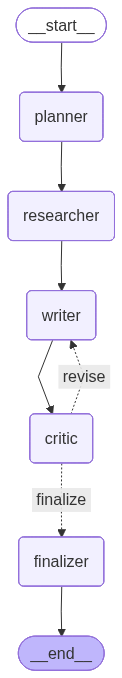

In [ ]:
#visualize graph


try:
    from IPython.display import Image, display
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Graph visualization skipped:", e)


##Run the Multi-Agent Graph

In [ ]:
initial_state: GraphState = {
    "question": question,
    "plan": None,
    "research_notes": [],
    "draft": None,
    "critique": None,
    "iteration": 0,
    "max_iterations": 2,
}



result = app.invoke(initial_state)
print(result["draft"])


# Should a Startup Use Open-Source LLMs or Closed Models in 2026?

## Introduction
The decision between utilizing open-source LLMs (Large Language Models) and closed models is pivotal for startups in 2026, significantly impacting cost, speed, privacy, and reliability. This analysis provides a comprehensive evaluation of each aspect, enabling startups to make informed decisions tailored to their specific needs.

## Cost Analysis
### Open-Source LLMs
- **Initial Costs**: Generally lower, as many open-source models are free to use. However, startups should anticipate costs related to infrastructure, maintenance, and potentially hiring specialized talent for implementation and customization.
- **Long-Term Savings**: Significant savings can be realized if the model can be adapted without incurring licensing fees. For instance, a startup using Hugging Face’s Transformers can avoid subscription fees associated with closed models.

### Closed Models
- **Pricing Structure**: Often involves subs

# compare single vs multi agents

In [ ]:
def run_comparison(question: str):
    print("====== Single Agent ======")
    print(single_agent_answer(question))
    print("\n\n====== Multi-Agent (LangGraph) ======")
    initial_state: GraphState = {
        "question": question,
        "plan": None,
        "research_notes": [],
        "draft": None,
        "critique": None,
        "iteration": 0,
        "max_iterations": 2,
    }
    result = app.invoke(initial_state)
    print(result["draft"])

run_comparison("Should I build my AI product on open-source LLMs (self-hosted) or closed APIs in 2026 if I handle sensitive customer data?")


====== Single Agent ======
### Summary
When deciding whether to build your AI product on open-source large language models (LLMs) that are self-hosted or on closed APIs, especially when handling sensitive customer data, there are several factors to consider. The choice will significantly impact data security, control, scalability, and compliance with regulations.

### Pros and Cons

#### Open-Source LLMs (Self-Hosted)

**Pros:**
1. **Data Control:** You have complete control over your data, which is crucial for handling sensitive information. This minimizes the risk of data leaks.
2. **Customization:** Open-source models can be tailored to meet specific needs, allowing for better alignment with your product's requirements.
3. **Cost-Effectiveness:** Once set up, self-hosted solutions can be more cost-effective in the long run, especially if usage scales.
4. **Transparency:** Open-source models allow for greater transparency in how data is processed and how the model operates.

**Cons:*

#Lets try few questions

In [ ]:
questions = [
    "Should a startup use open-source LLMs or closed models in 2026? Consider cost, speed, privacy, and reliability.",
    "We are in healthcare. Which approach is safer for compliance and auditability?",
    "We need extremely low latency on-device. What should we choose and why?",
]

for q in questions:
    _ = single_agent_answer(q)
    _ = app.invoke({
        "question": q,
        "plan": None,
        "research_notes": [],
        "draft": None,
        "critique": None,
        "iteration": 0,
        "max_iterations": 1,
    })  # traced

print("Done. Open LangSmith project to compare traces and outputs.")


Done. Open LangSmith project to compare traces and outputs.
